In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/word-difficulty/WordDifficulty.csv


In [2]:
# following https://github.com/garain/Word-Difficulty-Prediction/blob/master/WORD_DIFFICULTY.pdf

In [3]:
df = pd.read_csv('/kaggle/input/word-difficulty/WordDifficulty.csv')

In [4]:
df = df[['Word', 'I_Zscore']]

In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(40467, 2)

In [7]:
df.isnull().count()

Word        40467
I_Zscore    40467
dtype: int64

In [8]:
df = df.assign(label=np.where(df['I_Zscore'] <= 0, 0, 1))

In [9]:
df['Word'] = df['Word'].str.lower()

In [10]:
df

,Word,I_Zscore,label
0,a,-0.01,0
1,aah,0.21,1
2,aaron,-0.11,0
3,aback,0.11,1
4,abacus,0.65,1
...,...,...,...
40476,zooms,-0.48,0
40477,zucchini,0.24,1
40478,zurich,0.09,1
40479,false,-0.16,0


In [11]:
df['label'].value_counts()

label
0    22629
1    17838
Name: count, dtype: int64

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.utils import to_categorical
import tensorflow as tf

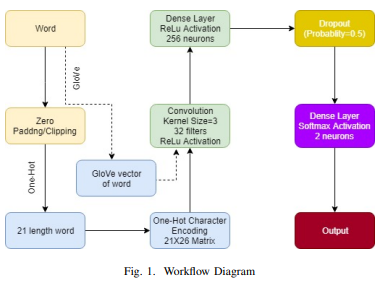

In [13]:
def char_to_int(char):
    if 'a' <= char <= 'z':
        return ord(char) - 97
    else:
        return None

def word_to_ints(word, max_len=21):
   ints = [char_to_int(char) for char in word[:max_len] if char_to_int(char) is not None]
   return ints + [0]*(max_len - len(ints))

def one_hot_encode(nums, num_classes=26):
  return np.eye(num_classes)[nums]

words = df['Word']

encoded_words = []
for word in words:
   ints = word_to_ints(word)
   one_hot = [one_hot_encode(num) for num in ints]
   encoded_words.append(np.array(one_hot))

encoded_words = np.array(encoded_words)
encoded_words

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [14]:
encoded_words.shape

(40467, 21, 26)

In [15]:
model = Sequential()

# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(21, 26)))

# Pooling Layer
model.add(MaxPooling1D(pool_size=2))

# Flattening Layer
model.add(Flatten())

# Dense Layer with 256 neurons
model.add(Dense(256, activation='relu'))

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer with softmax activation
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(encoded_words, df['label'], test_size=0.2, random_state=42)

# Convert target labels to one-hot encoded vectors
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Force TensorFlow to run functions eagerly
tf.config.run_functions_eagerly(True)

# Train the model
model.fit(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels))

# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy: ", accuracy)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1012/1012 [==============================] - 40s 39ms/step - loss: 0.5824 - accuracy: 0.6960 - val_loss: 0.5617 - val_accuracy: 0.7083
Epoch 2/10
1012/1012 [==============================] - 41s 40ms/step - loss: 0.5626 - accuracy: 0.7080 - val_loss: 0.5709 - val_accuracy: 0.7026
Epoch 3/10
1012/1012 [==============================] - 39s 38ms/step - loss: 0.5524 - accuracy: 0.7185 - val_loss: 0.5484 - val_accuracy: 0.7205
Epoch 4/10
1012/1012 [==============================] - 39s 39ms/step - loss: 0.5450 - accuracy: 0.7225 - val_loss: 0.5502 - val_accuracy: 0.7218
Epoch 5/10
1012/1012 [==============================] - 39s 39ms/step - loss: 0.5380 - accuracy: 0.7298 - val_loss: 0.5453 - val_accuracy: 0.7257
Epoch 6/10
1012/1012 [==============================] - 40s 39ms/step - loss: 0.5300 - accuracy: 0.7343 - val_loss: 0.5453 - val_accuracy: 0.7225
Epoch 7/10
1012/1012 [==============================] - 41s 41ms/step - loss: 0.5221 - accuracy: 0.7420 - val_loss: 0.5465 - val_accura